<a href="https://colab.research.google.com/github/nedokormysh/GB_App_Statistics_Med/blob/lesson_5_resampling/GB_app_statistics_med_hw_5_dirty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Урок 5.
Пермутационный тест, бутстрап анализ

# Условие
Ранее мы выяснили, что размеры выборок в имеющихся данных малы.

Попробуйте протестировать несколько гипотез из предыдущих заданий с использованием материала, полученного на этом занятии. Изменились ли результаты?

Задание выполняется на языке R и предоставляется в Google Colab или PDF/html рендере Quarto.

In [ ]:
packageVersion("rlang")
packageVersion("tidyverse")
packageVersion("dplyr")


[1] ‘1.0.1’

[1] ‘1.3.1’

[1] ‘1.0.8’

In [ ]:
install.packages('skimr')
install.packages("boot")
install.packages("bootstrap")
# install.packages('psych')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
library(tidyverse)
library(dplyr)
require(readxl)
library(httr)
library(skimr)
library("boot")
library("bootstrap")

# Загрузка данных

In [ ]:
hdl <- read_tsv('https://raw.githubusercontent.com/nedokormysh/GB_App_Statistics_Med/lesson_2_descriptive_statistics/high_density_lipids.tsv') |>
  select(-Name) |>
  mutate(Patient.number = as.factor(Patient.number),
         Vial.number = as.factor(Vial.number))

ldl <- read_tsv('https://raw.githubusercontent.com/nedokormysh/GB_App_Statistics_Med/lesson_2_descriptive_statistics/low_density_lipids.tsv') |>
  select(-Name) |>
  mutate(Patient.number = as.factor(Patient.number),
         Vial.number = as.factor(Vial.number))

# lipids <- full_join(hdl, ldl, by = c("Vial.number", "Patient.number"),
#  suffix = c('hdl', 'ldl'))

lipids <- merge(hdl, ldl, by = c("Vial.number", "Patient.number"),
                all = TRUE, suffix = c('_hdl', '_ldl'))

Rows: 27 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): Name
dbl (37): Vial.number, Patient.number, GPHDL1, GPHDL2, GPHDL3, GPHDL4, GPHDL...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 29 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): Name
dbl (37): Vial.number, Patient.number, GPLDL1, GPLDL2, GPLDL3, GPLDL4, GPLDL...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
url <- 'https://github.com/nedokormysh/GB_App_Statistics_Med/raw/lesson_2_descriptive_statistics/metadata.xlsx'

response <- GET(url, write_disk("metadata.xlsx", overwrite = TRUE))

meta <- read_xlsx('/content/metadata.xlsx', sheet = 1) |>
  rename_with(make.names)

descriptive <- read_xlsx('/content/metadata.xlsx', sheet = 2) |>
  rename('Variable' = '...1', 'Description' = '...2') |>
  drop_na()

descriptive <- descriptive %>%
  mutate(Variable = ifelse(row_number() == 10, "LVH", Variable))

for (col_name in colnames(meta)) {
  index <- match(col_name, descriptive$Variable)

  if (!is.na(index)) {
    attr(meta[[col_name]], 'label') <- descriptive$Description[index]
  }
}

In [ ]:
# Выбираем столбцы с данными пациентов
patient_cols <- c('Vial.number',
                  'Patient.number',
                  'Name',
                  'Date',
                  'Age')


# Создаем таблицу с данными пациентов
patient_data <- meta[patient_cols]

# Создаем таблицу с клиническими данными
clinical_data <- meta |> select(-Name, -Age, -Date, -Sucrose)

# заменяем 3 точки на точку во всех названиях столбцов
colnames(clinical_data) <- sub("\\.+", ".", colnames(clinical_data))

colnames_factor = c('Vial.number', 'Patient.number', 'Group', 'Sm', 'Dm', 'HT',
                    'LVH', 'IHD', 'MI', 'Str', 'A_C', 'A_H', 'A_D', 'Plaque',
                    'Statins')

# преобразуем указанные столбцы в фактор
clinical_data[, colnames_factor] <- lapply(clinical_data[, colnames_factor], as.factor)

# Гипотезы

## Гипотеза 1:
У пациентов с сахарным диабетом (Dm=1) средний уровень триглицеридов (Tgi) выше, чем у пациентов без сахарного диабета (Dm=0).

**Нулевая гипотеза (H0):** Средний уровень триглицеридов у пациентов с сахарным диабетом равен среднему уровню триглицеридов у пациентов без сахарного диабета.

**Альтернативная гипотеза (H1):** Средний уровень триглицеридов у пациентов с сахарным диабетом выше, чем средний уровень триглицеридов у пациентов без сахарного диабета.

ЗП - уровень триглицеридов.

НП - наличие сахарного диабета.

Независимые выборки.

In [ ]:
clinical_data_no_na <- na.omit(clinical_data)

Ранее определили, что у нас ненормальное распределение и использовали непараметрический тест Манна-Уитни. наблюдаемое различие между группами не является статистически значимым при уровне значимости 0.05.

In [ ]:
mann_whitney_test_decision <- function(formula, data) {
  # Выполняем тест Манна-Уитни
  test_result <- wilcox.test(formula, data = data, alternative = "two.sided", exact = FALSE)

  # Извлекаем p-значение
  p_value <- test_result$p.value

  # Делаем вывод о нулевой гипотезе
  if (p_value < 0.05) {
    decision <- "Отвергаем нулевую гипотезу"
  } else {
    decision <- "Не отвергаем нулевую гипотезу"
  }

  # Выводим результаты
  cat("Результаты теста Манна-Уитни:\n")
  cat("W-статистика: ", test_result$statistic, "\n")
  cat("p-значение: ", p_value, "\n")
  cat("Решение: ", decision, "\n")
}

In [ ]:
mann_whitney_test_decision(Tgi.26 ~ Dm, data = clinical_data_no_na)

Результаты теста Манна-Уитни:
W-статистика:  42.5 
p-значение:  0.8376886 
Решение:  Не отвергаем нулевую гипотезу 


In [ ]:
# вариант из лекции

# # Вычислим разницу средних значений между группами:

# ac_diffs <- clinical_data_no_na %>%
#   group_by(Dm) %>%
#   summarize(mean_tgi = mean(Tgi.26)) %>%
#   summarize(diff_tgi = diff(mean_tgi))

# # Зададим количество перестановок:
# reps <- 1000

# # Создадим пустой вектор для хранения перестановочных статистик:

# permdiffs <- c()

# # Выполним перестановочный тест:

# for(i in 1:reps) {
#   onediff <- clinical_data_no_na %>%
#     mutate(perm_dm = sample(Dm)) %>%
#     group_by(perm_dm) %>%
#     summarize(mean_tgi = mean(Tgi.26)) %>%
#     summarize(diff(mean_tgi)) %>% pull()

#   permdiffs <- c(permdiffs, onediff)
# }

# # Вычислим p-значение:

# p_value <- sum(permdiffs >= ac_diffs$diff_tgi) / reps


# # Выведем результаты:

# cat("Результаты перестановочного теста:\n")
# cat("Наблюдаемая разница между средними значениями: ", ac_diffs$diff_tgi, "\n")
# cat("p-значение: ", p_value, "\n")

# if (p_value < 0.05) {
#   decision <- "Отвергаем нулевую гипотезу"
# } else {
#   decision <- "Не отвергаем нулевую гипотезу"
# }

# cat("Решение: ", decision, "\n")

In [ ]:
permutation_bootstrap_jack_test <- function(formula, data, n_permutations = 10000, n_bootstraps = 1000) {
  # Извлекаем данные из формулы и данных
  y <- model.response(model.frame(formula, data))
  x <- model.matrix(formula, data)[, -1]

  # Вычисляем наблюдаемую разницу между средними значениями
  obs_diff <- mean(y[x == 1]) - mean(y[x == 0])

  # Вычисляем истинное среднее значение
  true_mean <- mean(y)

  # Инициализируем вектор для хранения перестановочных статистик
  perm_diffs <- numeric(n_permutations)

  # Выполняем перестановочные тесты
  for (i in 1:n_permutations) {
    # Перемешиваем метки классов
    x_perm <- sample(x)

    # Вычисляем перестановочную статистику
    perm_diffs[i] <- mean(y[x_perm == 1]) - mean(y[x_perm == 0])
  }

  # Вычисляем p-значение
  p_value <- sum(perm_diffs >= obs_diff) / n_permutations

  # Выполняем бутстреп-выборки
  boot_diffs <- numeric(n_bootstraps)
  for (i in 1:n_bootstraps) {
    # Генерируем выборку с заменой из исходных данных
    boot_sample <- sample(1:length(y), replace = TRUE)

    # Вычисляем бутстреп-статистику
    boot_diffs[i] <- mean(y[boot_sample][x[boot_sample] == 1]) - mean(y[boot_sample][x[boot_sample] == 0])
  }

  # Удаляем пропущенные значения или значения NaN из вектора boot_diffs
  boot_diffs_no_na <- na.omit(boot_diffs)

  # Вычисляем доверительный интервал для нашей оценки статистики
  conf_int <- quantile(boot_diffs_no_na, c(0.025, 0.975))

  # Вычисляем статистику jackknife
  jack_diffs <- numeric(length(y))
  for (i in 1:length(y)) {
    # Удаляем i-тое наблюдение из выборки
    y_jack <- y[-i]
    x_jack <- x[-i]

    # Вычисляем статистику jackknife
    jack_diffs[i] <- mean(y_jack[x_jack == 1]) - mean(y_jack[x_jack == 0])
  }

  # Вычисляем среднее и стандартное отклонение для статистики jackknife
  jack_mean <- mean(jack_diffs)
  jack_sd <- sd(jack_diffs)

  # Вычисляем доверительный интервал для статистики jackknife
  jack_conf_int <- jack_mean + c(-1, 1) * qt(0.975, length(y) - 1) * jack_sd / sqrt(length(y))

  # Делаем вывод о нулевой гипотезе
  if (p_value < 0.05) {
    decision <- "Отвергаем нулевую гипотезу"
  } else {
    decision <- "Не отвергаем нулевую гипотезу"
  }

  # Выводим результаты
  cat("Результаты перестановочного теста:\n")
  cat("Наблюдаемая разница между средними значениями групп: ", obs_diff, "\n")
  cat("Истинное среднее значение: ", true_mean, "\n")
  cat("p-значение: ", p_value, "\n")
  cat("Решение: ", decision, "\n")
  cat("\nРезультаты бутстреп-теста:\n")
  cat("Доверительный интервал: [", conf_int[1], ", ", conf_int[2], "]\n")

  # Делаем вывод о бутстреп-тесте
  if (conf_int[1] > 0 || conf_int[2] < 0) {
    bootstrap_decision <- "Отвергаем нулевую гипотезу"
  } else {
    bootstrap_decision <- "Не отвергаем нулевую гипотезу"
  }
  cat("Решение на основе бутстреп-теста: ", bootstrap_decision, "\n")

  cat("\nРезультаты jackknife-теста:\n")
  cat("Разница между средними значениями групп: ", jack_mean, "\n")
  cat("Стандартное отклонение: ", jack_sd, "\n")
  cat("Доверительный интервал: [", jack_conf_int[1], ", ", jack_conf_int[2], "]\n")

  # Делаем вывод на основе jackknife-теста
  if (jack_conf_int[1] > 0 || jack_conf_int[2] < 0) {
    jackknife_decision <- "Отвергаем нулевую гипотезу"
  } else {
    jackknife_decision <- "Не отвергаем нулевую гипотезу"
  }

  cat("Решение на основе jackknife-теста: ", jackknife_decision, "\n")
}


In [ ]:
permutation_bootstrap_jack_test(Tgi.26 ~ Dm, data = clinical_data_no_na)

Результаты перестановочного теста:
Наблюдаемая разница между средними значениями групп:  -7.326087 
Истинное среднее значение:  129.7407 
p-значение:  0.5286 
Решение:  Не отвергаем нулевую гипотезу 

Результаты бутстреп-теста:
Доверительный интервал: [ -61.96665 ,  41.84208 ]
Решение на основе бутстреп-теста:  Не отвергаем нулевую гипотезу 

Результаты jackknife-теста:
Разница между средними значениями групп:  -7.326087 
Стандартное отклонение:  5.821651 
Доверительный интервал: [ -9.629056 ,  -5.023118 ]
Решение на основе jackknife-теста:  Отвергаем нулевую гипотезу 


Насколько я понимаю: если доверительный интервал для разницы между средними значениями не включает ноль, мы можем отвергнуть нулевую гипотезу о том, что средние значения в группах равны. В противном случае, если доверительный интервал включает ноль, мы не можем отвергнуть нулевую гипотезу.

В нашем случае, jackknife-тест показывает, что разница между средними значениями групп статистически значима, в то время как перестановочный тест и бутстреп-тест не подтверждают это. Возможно это может быть вызвано тем, что jackknife-тест более чувствителен к выбросам и другим особенностям данных, которые могут влиять на статистику.

In [ ]:
# bootstrap ---------------------------------------------------------------

myfn_i <- function(x, i) {return(sum(x[i])/length(x[i]))}
myfn_w <- function(x, w) {return(sum(x*w)/length(x))}
result <- boot(clinical_data_no_na$Tgi.26, myfn_i, R = 999)


ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = clinical_data_no_na$Tgi.26, statistic = myfn_i, R = 999)


Bootstrap Statistics :
    original    bias    std. error
t1* 129.7407 0.1882994    12.57006

2.5%    97.5% 
107.9574 156.3370

[1] 129.7407

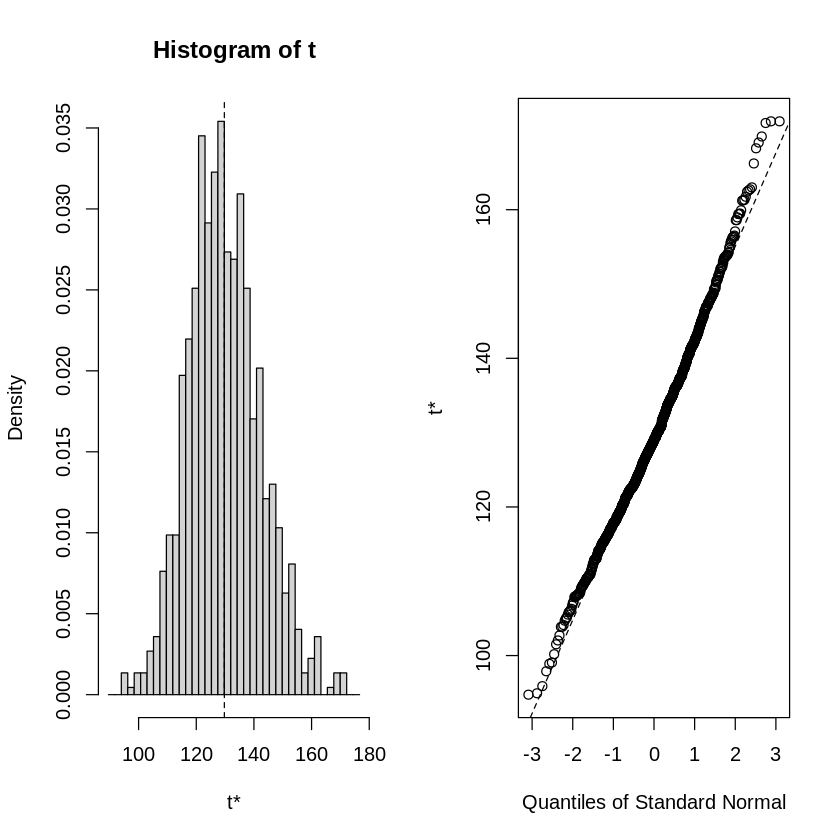

In [ ]:
result
plot(result)
quantile(result$t, c(0.025, 0.975))
mean(clinical_data_no_na$Tgi.26)

Распределение средних - нормальное. Среднее совпадает со средним полученным на бутстрепе.

$jack.se
[1] 12.5752

$jack.bias
[1] 0

$jack.values
 [1] 129.1154 129.6538 130.0769 130.3462 129.2308 122.9231 130.2308 128.8077
 [9] 130.6923 128.4231 129.5769 133.3846 127.7308 130.3462 131.8462 122.5385
[17] 132.7308 130.6923 132.1154 130.2308 132.2692 127.9615 131.1538 132.8077
[25] 130.0385 128.3077 129.7692

$call
jackknife(x = clinical_data_no_na$Tgi.26, theta = theta)


Warning message:
“Ignoring unknown parameters: pty”
Warning message:
“Ignoring unknown parameters: pty”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



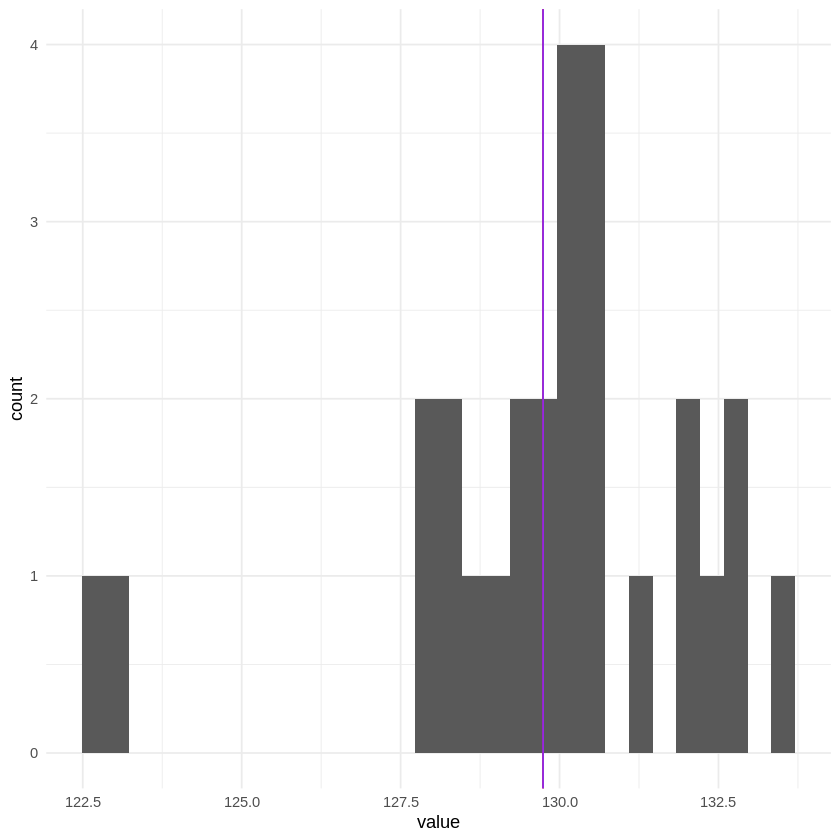

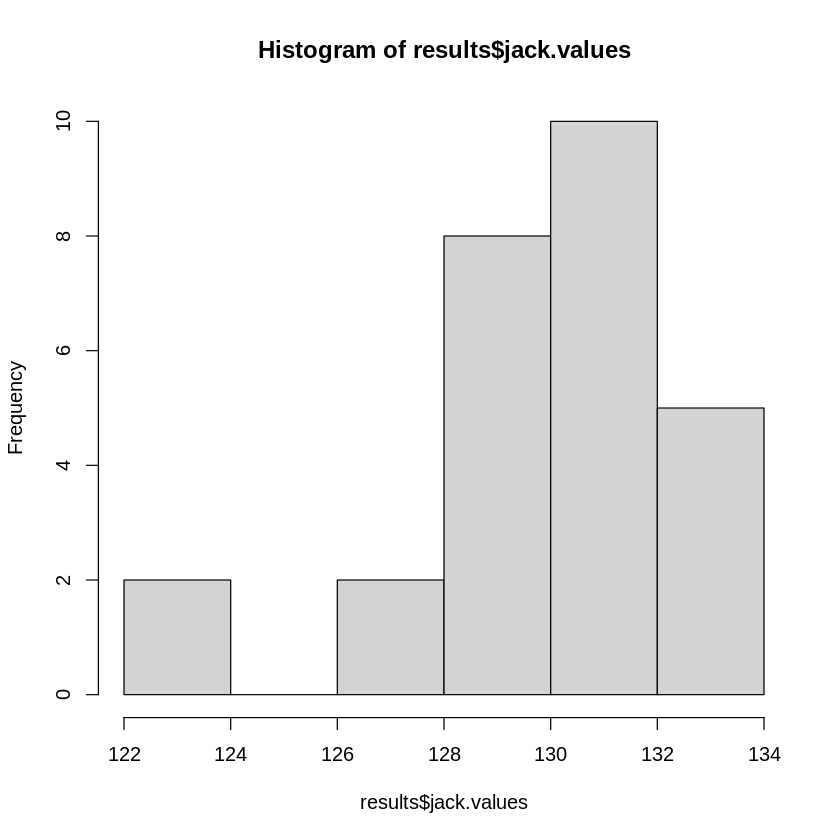

In [ ]:
# jackknife ----------------------------------------------------------------

theta <- function(x){mean(x)}

results <- jackknife(clinical_data_no_na$Tgi.26, theta)
results

ggplot(as_tibble(results$jack.values), aes(value)) +
  geom_histogram() +
  geom_vline(xintercept = mean(clinical_data_no_na$Tgi.26), color = 'red3', pty = 1) +
  geom_vline(xintercept = mean(results$jack.values), color = 'purple2', pty = 1) +
  theme_minimal()

hist(results$jack.values)

## Гипотеза 2:

У пациентов с гипертонией (HT=1) средний уровень холестерина (Choi) выше, чем у пациентов без гипертонии (HT=0).

**Нулевая гипотеза (H0):** Средний уровень холестерина у пациентов с гипертонией равен среднему уровню холестерина у пациентов без гипертонии.

**Альтернативная гипотеза (H1):** Средний уровень холестерина у пациентов с гипертонией выше, чем средний уровень холестерина у пациентов без гипертонии.

ЗП - общий уровень холистерина.

НП - наличие гипертонии.

Независимые выборки.

Тут вроде бы можем использовать t-test.

In [ ]:
t_test_decision <- function(formula, data) {
  # Выполняем t-тест
  test_result <- t.test(formula, data = data, na.action = na.omit)
  # Извлекаем p-значение
  p_value <- test_result$p.value

  # Делаем вывод о нулевой гипотезе
  if (p_value < 0.05) {
    decision <- "Отвергаем нулевую гипотезу"
  } else {
    decision <- "Не отвергаем нулевую гипотезу"
  }

  # Выводим результаты
  cat("Результаты теста t-теста:\n")
  cat("W-статистика: ", test_result$statistic, "\n")
  cat("p-значение: ", p_value, "\n")
  cat("Решение: ", decision, "\n")
}

In [ ]:
t_test_decision(Choi.25 ~ HT, data = clinical_data)

Результаты теста t-теста:
W-статистика:  -0.7849318 
p-значение:  0.4378333 
Решение:  Не отвергаем нулевую гипотезу 


In [ ]:
permutation_bootstrap_jack_test(Choi.25 ~ HT, data = clinical_data)

Результаты перестановочного теста:
Наблюдаемая разница между средними значениями групп:  10.25217 
Истинное среднее значение:  240.6053 
p-значение:  0.2217 
Решение:  Не отвергаем нулевую гипотезу 

Результаты бутстреп-теста:
Доверительный интервал: [ -11.68512 ,  34.88357 ]
Решение на основе бутстреп-теста:  Не отвергаем нулевую гипотезу 

Результаты jackknife-теста:
Разница между средними значениями групп:  10.25217 
Стандартное отклонение:  2.20874 
Доверительный интервал: [ 9.526179 ,  10.97817 ]
Решение на основе jackknife-теста:  Отвергаем нулевую гипотезу 
